In [1]:
import pycomod as pcm

In [2]:
class basic(pcm.Model):
    def build(self):
        self.P1 = pcm.Pool(20)
        self.P2 = pcm.Pool(20)
        
        self.a_v = pcm.Parameter([0.002, 0.01, 0.05])
        self.a_t = pcm.Parameter([0, 50, 100])
        
        self.a = pcm.Step(self.a_v(), self.a_t())
        
        self.F1 = pcm.Flow(lambda: self.P1()*self.a(), src=self.P1)
        self.F2 = pcm.Flow(lambda: self.P2()*self.a(), src=self.P2, discrete=True)
        
        self.set_output('P1', 'P2')
        

m = basic()

In [3]:
# Write excel
m.write_excel_init()

In [4]:
# Run
mgr = pcm.RunManager()
mgr.run(m, duration=150, label='My run')

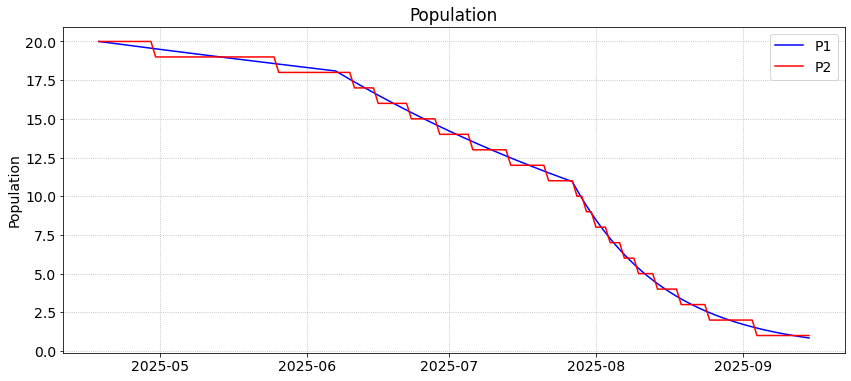

In [5]:
# Plot
plt = pcm.Plotter(title='Population', ylabel='Population', fontsize=14)
plt.plot(mgr['My run'], 'P1', color='blue', label='P1')
plt.plot(mgr['My run'], 'P2', color='red', label='P2')